In [18]:
#import libaries used to explore data and build model
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import both datasets and combine into NEW dataset total
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total = train.append(test, ignore_index=True, sort=False)

In [3]:
#Get the info in dataset
print(total.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


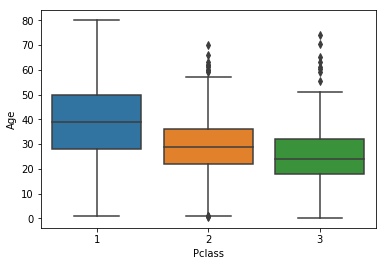

In [4]:
#Explore the data
sns.boxplot(x='Pclass', y='Age', data=total);

In [5]:
#Set the null values for age = to mean for Pclass
age_index1 = total[(total['Pclass'] == 1) & 
                   (total['Age'].isnull() == True)].index
                   
age_index2 = total[(total['Pclass'] == 2) & 
                   (total['Age'].isnull() == True)].index

age_index3 = total[(total['Pclass'] == 3) & 
                   (total['Age'].isnull() == True)].index
                   
total['Age'].loc[age_index1] = total[total['Pclass'] == 1]['Age'].mean()
total['Age'].loc[age_index2] = total[total['Pclass'] == 2]['Age'].mean()
total['Age'].loc[age_index3] = total[total['Pclass'] == 3]['Age'].mean()

/Users/kylebowling/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#Derive new column title
def get_title(name):
    lst = name.split(',')
    lst2 = lst[1].split('.')
    return lst2[0].lstrip()

total['Title'] = total['Name'].apply(get_title)

#Many titles - converting infrequent titles to other category
title_index = total[(total['Title'] != 'Mr') & (total['Title'] != 'Mrs') & 
                    (total['Title'] != 'Miss') & 
                    (total['Title'] != 'Master')].index
total['Title'].loc[title_index] = 'Other'

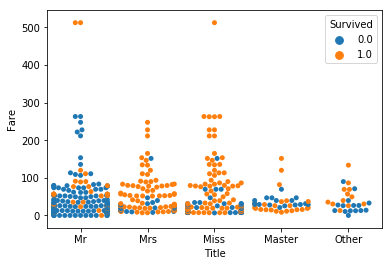

In [7]:
#Swarm plot to explore title
sns.swarmplot(x='Title',y='Fare',data=total,hue='Survived');

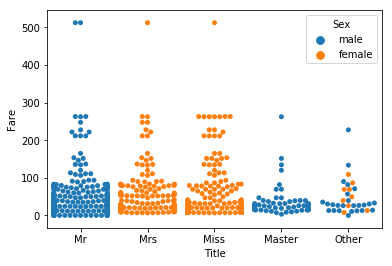

In [8]:
#Swarm plot to explore title
sns.swarmplot(x='Title',y='Fare',data=total,hue='Sex');

In [9]:
#Drop columns not used in analysis
total.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

In [10]:
#Set null for fare = mean
fare_index = total[total['Fare'].isnull() == True].index
total['Fare'].loc[fare_index] = total['Fare'].mean()

In [11]:
#Convert sex to 0:1
total['Sex'] = total['Sex'].map({'male':0,'female':1})

In [12]:
#Standardize Fare and Age
total['Age'] = scale(total['Age'])
total['Fare'] = scale(total['Fare'])

In [13]:
#Set missing Embarked values to most frequent - S
print(total['Embarked'].value_counts())
embarked_index = total[total['Embarked'].isnull() == True].index
total['Embarked'].loc[embarked_index] = 'S'

S    914
C    270
Q    123
Name: Embarked, dtype: int64


/Users/kylebowling/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
#Convert Embarked, Title, Pclass into dummy variables
total = pd.get_dummies(total, columns=['Pclass', 'Embarked', 'Title'])

In [15]:
#drop 1 of dummy variable columns
total.drop(axis=1,columns=['Pclass_2','Embarked_Q','Title_Other'],inplace=True)

In [16]:
#Split back into train and test
train_index = total[total['Survived'].isnull() == False].index
test_index = total[total['Survived'].isnull() == True].index
train = total.loc[train_index]
test = total.loc[test_index]
test.drop(['Survived'],axis=1,inplace=True)

In [21]:
#Fit the model
X = np.array(train.drop(axis=1, columns=['Survived','PassengerId']))
y = np.array(train['Survived'])
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [i for i in range(1,50)]}
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
grid = GridSearchCV(knn, param_grid, cv = cv, scoring='accuracy',
                    return_train_score=True)
grid.fit(X, y)
print("Best Parameter: {}".format(grid.best_params_))
print("Best Cross Vlidation Score: {}".format(grid.best_score_))
best_param = grid.best_params_['n_neighbors']

knn = KNeighborsClassifier(n_neighbors=best_param)

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.00, 
                                                    random_state=0)
knn.fit(x_train, y_train)
y_hat = knn.predict(x_train)

accuracy_score(y_train, y_hat, normalize=True) * 100
print(classification_report(y_train,y_hat))
print(confusion_matrix(y_train,y_hat))

Best Parameter: {'n_neighbors': 3}
Best Cross Vlidation Score: 0.8237934904601572
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       549
         1.0       0.85      0.82      0.83       342

   micro avg       0.87      0.87      0.87       891
   macro avg       0.87      0.86      0.87       891
weighted avg       0.87      0.87      0.87       891

[[500  49]
 [ 63 279]]


In [20]:
#Apply the model to test
X = np.array(test.drop(axis=1,columns=['PassengerId']))
y_hat_test = knn.predict(X)

survived_prediction = pd.Series(y_hat_test)
test = test.reset_index()
test.drop(['index'],axis=1,inplace=True)
test['Survived'] = survived_prediction
test.to_csv('Kaggle Titanic Model 1.csv')

In [ ]:
#Kaggle Score on Test: 0.75598